---

# <center> Regularized Linear Regression from Scratch </center> <br> 
<center>Prepared by Wyatt Walsh</center>

---

This project serves to explore multiple linear regression with several forms of regularization as applied to predication of wine quality given numerical features. Furthermore, an emphasis is given to the underlying algorithms that produce these models and both explanations and implementations are made.  The wine quality dataset was obtained through the final class project for Engineering Statistics, Quality Control, and Forecasting (IEOR 165) at UC Berkeley. 

The dataset contains numerous numerical qualities for wine samples as well as their corresponding quality rating. Ordinary Least Squares, Ridge regression, the Lasso, and the Elastic Net are implemented and applied to the dataset. Furthermore, K-Fold cross-validation is implemented and utilized in determination of model hyperparameters. Model coefficient paths across varying hyperparameter values are visualized.

Validation of the implementations of the modelling algorithms is sought through comparison with the popular Scikit-Learn package. Efficiency and accuracy of the models is determined and compared against the results from the corrsponding Scikit-Learn function with the implemented results generally surpassing those of Scikit-Learn. 

---

<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Dependencies-and-Configure-Environment" data-toc-modified-id="Import-Dependencies-and-Configure-Environment-1">Import Dependencies and Configure Environment</a></span></li><li><span><a href="#Import-Data" data-toc-modified-id="Import-Data-2">Import Data</a></span></li><li><span><a href="#Train-Test-Data-Splitting" data-toc-modified-id="Train-Test-Data-Splitting-3">Train Test Data Splitting</a></span></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-4">Exploratory Data Analysis</a></span><ul class="toc-item"><li><span><a href="#Variable-Summarization-and-Ensuring-Data-Cleanliness" data-toc-modified-id="Variable-Summarization-and-Ensuring-Data-Cleanliness-4.1">Variable Summarization and Ensuring Data Cleanliness</a></span></li><li><span><a href="#Evaluation-for-Multicollinearity-between-Features" data-toc-modified-id="Evaluation-for-Multicollinearity-between-Features-4.2">Evaluation for Multicollinearity between Features</a></span><ul class="toc-item"><li><span><a href="#Scatterplot-Matrix" data-toc-modified-id="Scatterplot-Matrix-4.2.1">Scatterplot Matrix</a></span></li><li><span><a href="#Correlation-Heatmap" data-toc-modified-id="Correlation-Heatmap-4.2.2">Correlation Heatmap</a></span></li><li><span><a href="#VIF-Calculation" data-toc-modified-id="VIF-Calculation-4.2.3">VIF Calculation</a></span></li></ul></li></ul></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-5">Modeling</a></span><ul class="toc-item"><li><span><a href="#Ordinary-Least-Squares" data-toc-modified-id="Ordinary-Least-Squares-5.1">Ordinary Least Squares</a></span><ul class="toc-item"><li><span><a href="#Deriving-the-Ordinary-Least-Squares-Estimator" data-toc-modified-id="Deriving-the-Ordinary-Least-Squares-Estimator-5.1.1">Deriving the Ordinary Least Squares Estimator</a></span></li><li><span><a href="#Notes-on-Implementation" data-toc-modified-id="Notes-on-Implementation-5.1.2">Notes on Implementation</a></span></li><li><span><a href="#Comparisons-with-Scikit-Learn" data-toc-modified-id="Comparisons-with-Scikit-Learn-5.1.3">Comparisons with Scikit-Learn</a></span></li></ul></li><li><span><a href="#Ridge-Regression" data-toc-modified-id="Ridge-Regression-5.2">Ridge Regression</a></span><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-5.2.1">Introduction</a></span></li><li><span><a href="#Deriving-the-Ridge-Estimator" data-toc-modified-id="Deriving-the-Ridge-Estimator-5.2.2">Deriving the Ridge Estimator</a></span></li><li><span><a href="#Comparisons-with-Scikit-Learn" data-toc-modified-id="Comparisons-with-Scikit-Learn-5.2.3">Comparisons with Scikit-Learn</a></span></li><li><span><a href="#Coefficient-Path-Visualization" data-toc-modified-id="Coefficient-Path-Visualization-5.2.4">Coefficient Path Visualization</a></span></li></ul></li><li><span><a href="#The-Lasso-(Least-Absolute-Shrinkage-and-Selection-Operator)" data-toc-modified-id="The-Lasso-(Least-Absolute-Shrinkage-and-Selection-Operator)-5.3">The Lasso (Least Absolute Shrinkage and Selection Operator)</a></span><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-5.3.1">Introduction</a></span></li><li><span><a href="#Solving-the-Lasso" data-toc-modified-id="Solving-the-Lasso-5.3.2">Solving the Lasso</a></span></li><li><span><a href="#Comparisons-with-Scikit-Learn" data-toc-modified-id="Comparisons-with-Scikit-Learn-5.3.3">Comparisons with Scikit-Learn</a></span></li><li><span><a href="#Coefficient-Path-Visualization" data-toc-modified-id="Coefficient-Path-Visualization-5.3.4">Coefficient Path Visualization</a></span></li></ul></li><li><span><a href="#The-Elastic-Net" data-toc-modified-id="The-Elastic-Net-5.4">The Elastic Net</a></span><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-5.4.1">Introduction</a></span></li><li><span><a href="#Solving-the-Elastic-Net" data-toc-modified-id="Solving-the-Elastic-Net-5.4.2">Solving the Elastic Net</a></span></li><li><span><a href="#Comparisons-with-Scikit-Learn" data-toc-modified-id="Comparisons-with-Scikit-Learn-5.4.3">Comparisons with Scikit-Learn</a></span></li></ul></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6">Conclusion</a></span></li></ul></div>

---

## Import Dependencies and Configure Environment

In [1]:
# Libraries to load and prepare data
import numpy as np
import pandas as pd

# Custom libraries for utilities, modeling, cross-validation, and visualization
from src import utilities as utils
from src import linear_regression as lr
from src import cross_validation as cv
from src import visualization

# Plotting library and Jupyter configuration
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 50
pd.set_option("display.precision", 4)

---

## Import Data

In [2]:
# Import winequality-red.csv within the data directory into a Pandas dataframe and display beginning rows
wine_data_raw = pd.read_csv('data/winequality-red.csv', sep=';')
wine_data_raw.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


---

## Train Test Data Splitting

In [3]:
# Split dataset into training and testing sets
train_proportion = 0.8  # Define proportion of data in the training set
train, test = utils.test_train_split(wine_data_raw, train_proportion)

# Convert to NumPy and parse X, y columns from datasets
train_vals, test_vals = train.to_numpy(), test.to_numpy(
)  # Convert to NumPy matrices for efficiency
X_train = train_vals[:, 0:-1]
y_train = train_vals[:, [-1]]
X_test = test_vals[:, 0:-1]
y_test = test_vals[:, [-1]]

# Display training and testing sets and print number of rows in each
print('With a training proportion of {}, \
there are {} rows in the training set and {} rows in the test set'.format(
    train_proportion, len(train), len(test)))
display(train.head()), display(test.head());

With a training proportion of 0.8, there are 1279 rows in the training set and 320 rows in the test set


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.7,0.56,0.08,2.50,0.114,14.0,46.0,0.9971,3.24,0.66,9.6,6
1,7.8,0.50,0.17,1.60,0.082,21.0,102.0,0.9960,3.39,0.48,9.5,5
2,10.7,0.67,0.22,2.70,0.107,17.0,34.0,1.0004,3.28,0.98,9.9,6
3,8.5,0.46,0.31,2.25,0.078,32.0,58.0,0.9980,3.33,0.54,9.8,5
4,6.7,0.46,0.24,1.70,0.077,18.0,34.0,0.9948,3.39,0.60,10.6,6


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,8.0,0.28,0.44,1.8,0.081,28.0,68.0,0.9950,3.36,0.66,11.2,5
1,7.0,0.50,0.14,1.8,0.078,10.0,23.0,0.9964,3.53,0.61,10.4,5
2,6.0,0.50,0.00,1.4,0.057,15.0,26.0,0.9945,3.36,0.45,9.5,5
3,8.0,0.59,0.05,2.0,0.089,12.0,32.0,0.9973,3.36,0.61,10.0,5
4,6.5,0.53,0.06,2.0,0.063,29.0,44.0,0.9949,3.38,0.83,10.3,6


[Back to Top](#Table-of-Contents)

---

## Exploratory Data Analysis

Now that the data has been prepared for future modelling, exploratory data analysis (EDA) is conducted on the training data (to avoid data leakage).

This process consists of:

- Summarization of variables to better understand their values and ensure data cleanliness
- Scatterplot matrix creation to evaluate relationships betweeen predictors
- Correlation heatmap creation to evaluate possible multicollinearity between predictors
- Variance Inflation Factor analysis to also evaluate multicollinearity between predictors 

These methods should help to better characterize the dataset in order to properly model and rationalize model outputs.

---

### Variable Summarization and Ensuring Data Cleanliness
Here the number of unique values per variable, a summary of each variable's count, mean, standard deviation and major percentile values and number of missing values per variable is given.

In [4]:
display(pd.DataFrame(train.nunique(axis=0), columns=['Unique Value Count']).T)
display(
    pd.DataFrame(train.isna().sum(), columns=['Number of Missing Values']).T)
display(train.describe())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
Unique Value Count,94,138,78,86,146,58,142,395,87,90,61,6


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
Number of Missing Values,0,0,0,0,0,0,0,0,0,0,0,0


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1279.0000,1279.0000,1279.0000,1279.0000,1279.0000,1279.0000,1279.0000,1279.0000,1279.0000,1279.0000,1279.0000,1279.0000
mean,8.3239,0.5269,0.2699,2.5310,0.0879,15.7776,46.3620,0.9968,3.3106,0.6573,10.3967,5.6357
std,1.7537,0.1804,0.1917,1.4442,0.0481,10.4134,33.0939,0.0019,0.1553,0.1650,1.0683,0.8147
min,4.6000,0.1200,0.0000,0.9000,0.0120,1.0000,6.0000,0.9901,2.8600,0.3300,8.4000,3.0000
25%,7.1000,0.3900,0.1000,1.9000,0.0700,7.0000,22.0000,0.9956,3.2100,0.5500,9.5000,5.0000
50%,7.9000,0.5200,0.2500,2.2000,0.0790,13.0000,37.0000,0.9968,3.3100,0.6200,10.1000,6.0000
75%,9.2000,0.6375,0.4200,2.6000,0.0910,21.0000,62.0000,0.9978,3.4000,0.7300,11.1000,6.0000
max,15.9000,1.5800,0.7900,15.5000,0.6110,72.0000,289.0000,1.0037,4.0100,1.9800,14.9000,8.0000


### Evaluation for Multicollinearity between Features

Multicollinearity arises when there is significant interdependence found amongst the predictors and can have a negative impact when modelling. Thus, multicollinearity is assesed through evaluation of a scatterplot matrix (please be patient with this function as all predictors are numerical and thus a large matrix is produced), a numerical feature correlation heatmap, as well as variance inflation factor (VIF) measurement. 

#### Scatterplot Matrix


<Figure size 1000x500 with 0 Axes>

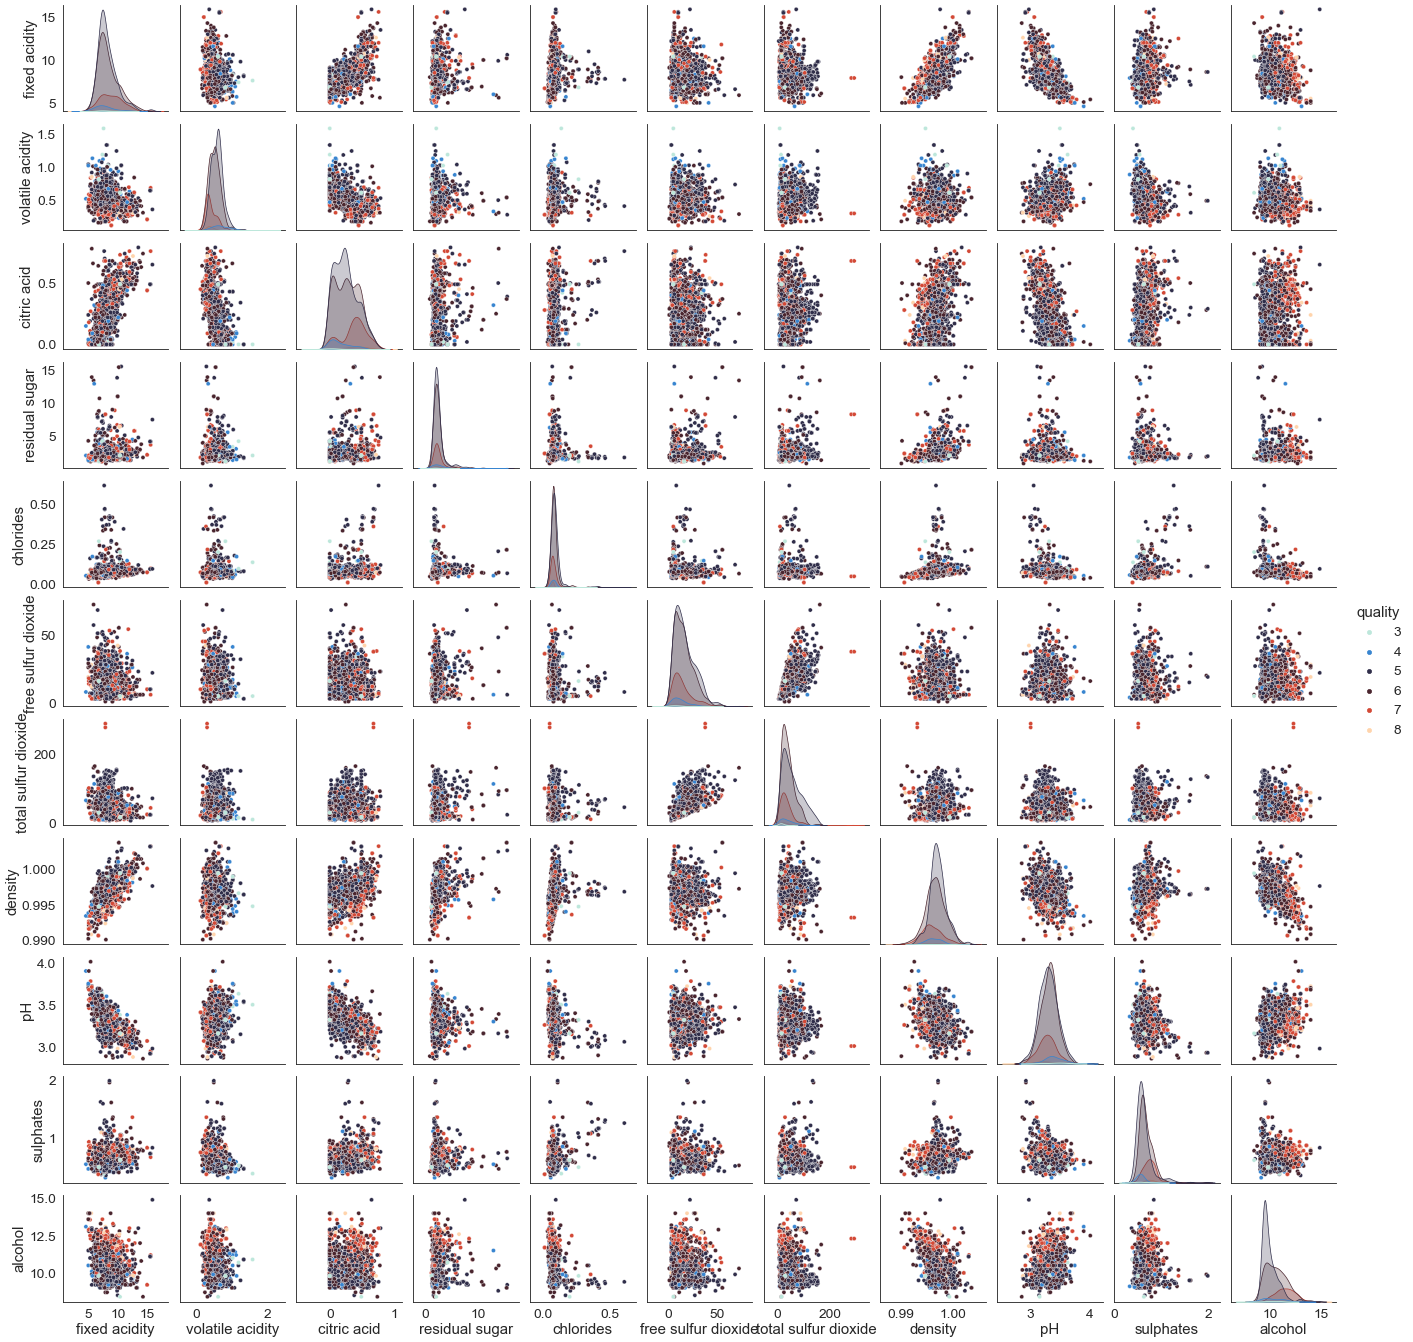

In [4]:
plt.figure(figsize=(20, 10))
visualization.scatter_matrix(train)

It seems that multicollinearity is low for this dataset as most of the scatterplots seem patternless. However, further analysis should be conducted to ensure this

#### Correlation Heatmap

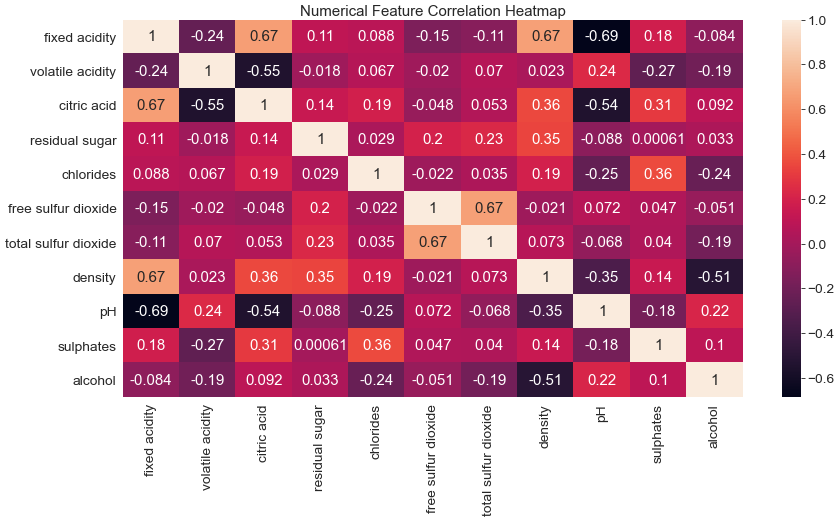

In [5]:
plt.figure(figsize=(20, 10))
visualization.correlation_heatmap(train)

It appears that the highest correlation value is -0.69 found between fixed acidity and pH followed by 0.67 found between fixed acidity and citric acid, fixed acidity and density and free sulfur dioxide and total sulfur dioxide. This value isn't incredibly high, but VIF analysis should determine if this is significant. 

#### VIF Calculation



In [4]:
utils.VIF(train)

Low Multicollinearity Detected


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,3.0739,1.7531,3.0586,1.1014,1.4605,1.9793,2.2318,-0.0052,2.2678,1.3496,1.3222


Since the result for all features is less than five, VIF analysis establishes the absence of significant multicollinearity for this dataset

[Back to Top](#Table-of-Contents)

---

## Modeling

Four predictive models are constructed from the training set and applied to the testing set: 

- [Ordinary Least Squares](#Ordinary-Least-Squares)
- [Ridge](#Ridge-Regression)
- [Lasso](#Lasso-Regression)
- [Elastic Net](#Elastic-Net-Regression)

To gauge the quality of my regression algorithm implementations, comparisons with the associated Scikit-Learn algorithm are detailed at the end of each section. Furthermore, to preserve the simplicity of this notebook, functions for linear regression are called from `src/linear_regression.py` with utilities used called from `src/utilities.py` and visualizations generated from `src/visualization.py`. K-Fold cross-validation is also implemented (found at `src/cross_validation.py`) using basic libraries and used for model hyperparameter tuning.

---

### Ordinary Least Squares

#### Deriving the Ordinary Least Squares Estimator

In an Ordinary Least Squares (OLS) model, the response is modeled as a linear function of its features:

$$y_i = \beta_1x_{i,1} + \beta_2x_{i,2} + \ldots + \beta_nx_{i,n} + \epsilon_i \space \forall \space i \in \{1, \ldots, N\} \: \: \: \: \: \text{(n ~ number of features, N ~ number of samples, $\epsilon$ ~ error)}$$


To solve for the OLS estimator, the sum of squared error will be utilized as a loss function, where error (or residual) is defined as: 

$$ \hat{\mathbf{e}} = \mathbf{y} - \mathbf{X}\mathbf{\beta} $$

and the corresponding loss function is:

$$ L(\mathbf{\beta}) = \|\hat{\mathbf{e}}\|_2^2 =  \|\mathbf{y} - \mathbf{X}\mathbf{\beta}\|_2^2$$

Furthermore, this problem can now be formalized as a least squares optimization problem, which serves to derive estimates for the model parameters, $\mathbf{\beta}$, that minimize the sum of squared error between actual and predicted values of the outcome: 

$$ \hat{\mathbf{\beta}} = \arg\min_{\mathbf{\beta}}  L(\mathbf{\beta}) = \arg\min_{\mathbf{\beta}} \|\mathbf{y}-\mathbf{X}\mathbf{\beta} \|_{2}^{2} $$

Aided by the problem's unconstrained nature, a closed-form solution for the OLS estimator can be derived by setting the gradient of the loss function (objective) equal to zero and solving the resultant equation, which produces:

$$ \hat{\mathbf{\beta}} = (\mathbf{X}^T\mathbf{X})^{-1}(\mathbf{X}^T\mathbf{y}) $$

To show that this solution is the unique (global) minimizer to the OLS problem, it will suffice to show that the loss function (3) is convex. Second-order convexity conditions state that a function is convex if it is continuous, twice differentiable, and has an associated  Hessian matrix that is positive semi-definite. 

Due to its quadratic nature, the OLS loss function (3) is both continuous and twice differentiable. To establish the last second-order condition, the Hessian matrix of the OLS loss function (3) is found as: 

$$\mathbf{H} = 2\mathbf{X}^T\mathbf{X} $$

Furthermore, this Hessian matrix can be shown to be positive semi-definite as:

$$ \mathbf{\beta}^T (2\mathbf{X}^T\mathbf{X}) \beta = 2(\mathbf{X}\beta)^T \mathbf{X}\beta = 2 \|\mathbf{X}\mathbf{\beta}\|_2^2 \succeq 0 \: \: \: \forall \: \: \: \mathbf{\beta}$$

Thus, by the second-order conditions for convexity, the OLS loss function (3) is convex. 

Therefore, any local minimum of this function is also a global minimum, which implies that the OLS estimator found above (5) is the unique minimizer to the least squares (OLS) regression problem.

--- 

In this particular application of OLS, an intercept term, $\beta_0$, should be included in the model. This can be accomplished through augmentation of the design matrix with a constant column of ones producing the optimization problem:

\begin{align}
\begin{bmatrix}
    \hat{\beta}_0\\
    \hat{\beta}\\
\end{bmatrix}
&=
\arg\min_{\beta_0,\beta} \left\Vert\mathbf{y}-\begin{bmatrix} \mathbf{1_n} & \mathbf{X} \end{bmatrix}\begin{bmatrix}
    \beta_0\\
    \beta\\
\end{bmatrix}\right\Vert^2 _2
\end{align}

This optimization problem can then be solved for the OLS estimator (5).

#### Notes on Implementation 

Solving for the OLS estimator using the matrix inverse does not scale well, thus the NumPy function `solve`, which employs the LAPACK `_gesv` routine, is used to find the least squares solution. This function solves the equation $Ax = b$ in the case where A is square ($X^TX$) and full-rank (linearly independent columns), which is our case (full-rank being established through VIF analysis). However, in the case that A is not full-rank, then the function `lstsq` should be used, which utilizes the xGELSD routine and thus finds the singular value decomposition of A.

#### Comparisons with Scikit-Learn

A table is produced below detailing Scikit-Learn comparison runtimes, errors, and model parameters outputs.

In [4]:
utils.compare_ols(X_train, y_train, test_vals, list(train.columns[0:-1]))

,Runtime (s),Error,Y-Intercept,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
My Function,0.000755,112.026172,22.464534,0.006538,-0.952018,-0.086144,0.00959,-1.923678,0.00493,-0.003642,-17.443395,-0.659216,0.985946,0.269186
Scikit-Learn's Function,0.001000,112.026172,22.464534,0.006538,-0.952018,-0.086144,0.00959,-1.923678,0.00493,-0.003642,-17.443395,-0.659216,0.985946,0.269186


---

### Ridge Regression

#### Introduction

One way the predictive capability of an OLS model can be hampered is by overfitting the training set data. 

Since our modelling data is a sample taken from an overall population, and furthermore our training data a subsample of this sample, error (noise) can be introduced by idiosyncrasies unique to the sample. When training on such a sample, a model can become overfit when it uses patterns and relationships found within the sample, but not within the underlying population to make its predictions. 

This results in a predictive model with high variance (parameter predictions vary greatly from sample to sample) and low bias (error introduced by the modelling technique), which is sub-optimal in its capabilities. One possible way to improve performance in this case is to reduce variance by adding bias to the model.

For the case of OLS, this can be achieved through biasing parameter predictions towards zero (shrinkage). Ridge Regression (also known as Tikhonov regularization or $L_2$-regularization) achieves this shrinkage of the OLS predictions through the addition of an $L_2$ penalty to the loss function. 

#### Deriving the Ridge Estimator

The Ridge loss function is similar to the OLS loss function (3) but with the addition of an $L_2$ penalty:

$$ L(\mathbf{\beta}) =  \|\mathbf{y} - \mathbf{X}\mathbf{\beta}\|_2^2 + \lambda\|\mathbf{\beta}\|_2^2 \: \: \: \text{ with tuning parameter $\lambda \geq 0$} $$

The Ridge problem is also formalized as a least squares optimization problem: 

$$ \hat{\mathbf{\beta}} = \arg\min_{\mathbf{\beta}}  L(\mathbf{\beta}) = \arg\min_{\mathbf{\beta}} \|\mathbf{y}-\mathbf{X}\mathbf{\beta} \|_{2}^{2} + \lambda\|\mathbf{\beta}\|_2^2 $$

A closed-form solution can be analytically derived for the Ridge estimator similarly to the OLS case:

$$ {\hat {\beta }}=(\mathbf {X} ^{\mathsf {T}}\mathbf {X} +\lambda \mathbf {I} )^{-1}\mathbf {X} ^{\mathsf {T}}\mathbf {y} $$

This estimator can be shown to be unique similarly to the OLS case. First, the Hessian matrix is computed:

$$\mathbf{H} = 2\mathbf{X}^T\mathbf{X} + 2 \lambda \mathbf {I}$$

Next, this matrix is shown to be positive definite, implying strong convexity, as:

$$ \mathbf{\beta}^T (\mathbf{X}^T\mathbf{X} + \lambda \mathbf {I})\mathbf{\beta} = (\mathbf{X}\mathbf{\beta})\mathbf{X}\mathbf{\beta} + \lambda \mathbf{\beta}^T\mathbf{\beta} = \|\mathbf{X}\mathbf{\beta}\|_2^2 + \lambda \|\mathbf{\beta}\|_2^2 \succ 0 \: \: \: \forall \:\:\:  \mathbf{\beta} \neq \mathbf{0}$$

Establishing that the Ridge loss function is strongly convex implies that the Ridge estimator is the unique minimizer to the Ridge problem (10)

Note: $\lambda = 0$ produces the OLS estimate. Furthermore, features should be centered and scaled to unit variance to enable fair parameter shrinkage.

---

To obtain an intercept term for the Ridge case, data augmentation is utilized again resulting in the following optimization problem which can be solved for the corresponding estimator:

\begin{align}
\begin{bmatrix}
    \hat{\beta}_0\\
    \hat{\mathbf{\beta}}\\
\end{bmatrix}
&=
\arg\min_{\beta_0,\beta} \left\Vert \begin{bmatrix}\mathbf{Y} \\ 0 \end{bmatrix}-\begin{bmatrix} \mathbf{1_n} & \mathbf{X} \\
                                                            0 & \lambda \cdot \mathbf{I} \end{bmatrix}\begin{bmatrix}
    \beta_0\\
    \mathbf{\beta}\\
\end{bmatrix}\right\Vert^2 _2
\end{align}

#### Comparisons with Scikit-Learn

First, the features are standardized, then a grid of tuning parameters is tested via five-fold cross-validation (CV). This grid consists of 500 values between 1e-6 and 5 on a log scale to enable a higher concentration of hyperparameters near zero to test via CV.

In [4]:
ridge_cv = cv.ridge(X_train, y_train, num_lambdas=5000, k=5)
lambda_star_ridge = ridge_cv[-1]
print("Optimal tuning parameter value: ", lambda_star_ridge)
utils.compare_ridge(X_train, y_train, test_vals, \
              features=list(train.columns[0:-1]), l=lambda_star_ridge)

Optimal tuning parameter value:  48.716669096196554


,Runtime (s),Error,Y-Intercept,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
My Function,0.001223,112.115609,5.635653,0.030661,-0.165394,-0.006682,0.019051,-0.088353,0.043995,-0.112447,-0.054633,-0.082888,0.158955,0.266367
Scikit-Learn's Function,0.002116,112.115609,5.635653,0.030661,-0.165394,-0.006682,0.019051,-0.088353,0.043995,-0.112447,-0.054633,-0.082888,0.158955,0.266367


#### Coefficient Path Visualization

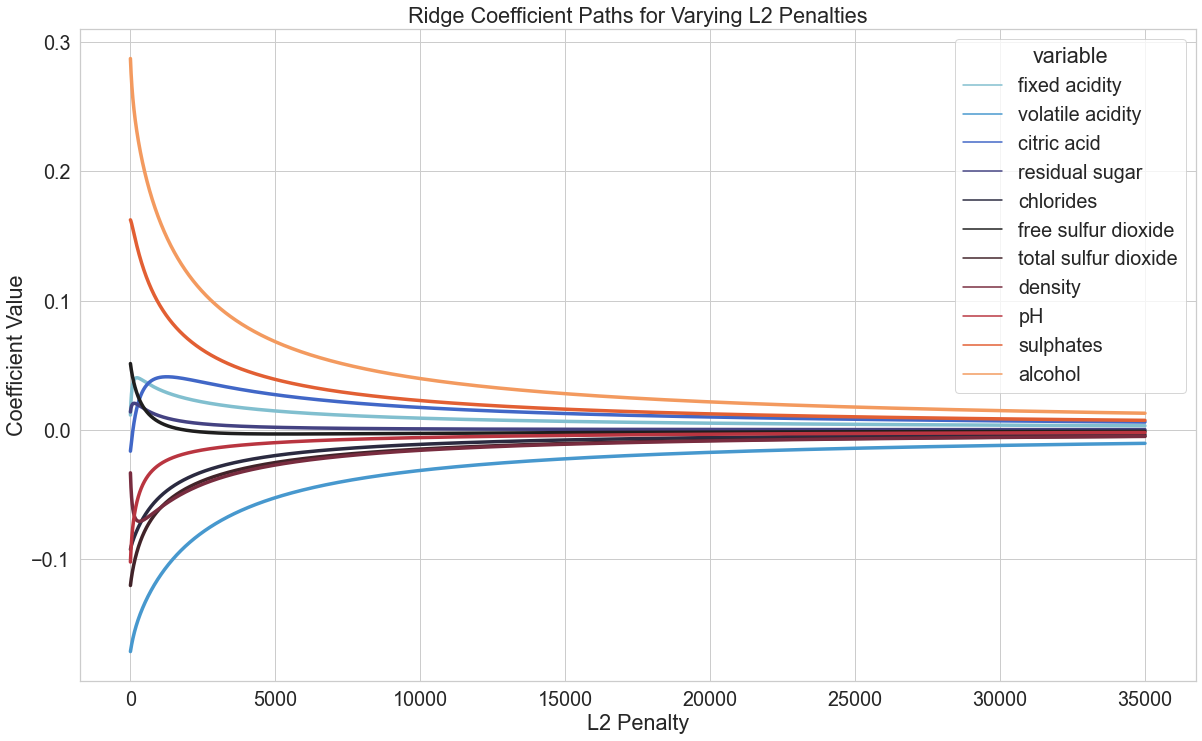

In [4]:
plt.figure(figsize=(20, 12))
visualization.ridge_plot(X_train,
                         y_train,
                         num_lambdas=5000,
                         features=list(train.columns[0:-1]))

---

### The Lasso (Least Absolute Shrinkage and Selection Operator)

#### Introduction

Another form of shrinkage that can be applied to the OLS problem is the Lasso. In this case, an $L_1$ penalty is added to the loss function, which has the effect of bringing model parameters to zero for a large enough value of the associated tuning parameter. In other words, this penalty performs automated feature selection since possibly some of the model parameters will be brought to zero.  

However, unlike the previous models, no closed-form solution exists due to the fact that the loss function is no longer continuously differentiable (non-smooth absolute component). Thus, discrete optimization techniques are needed to solve for the parameter estimates. Numerous algorithms, such as the LARS (Least Angle Regression) algorithm and the Forward Stepwise regression algorithm have been developed to solve the Lasso, however the Pathwise Coordinate Descent algorithm is leveraged here. 

#### Solving the Lasso

The Lasso loss function is similar to the OLS loss function (3) but with the addition of an $L_1$ penalty:

$$ L(\mathbf{\beta}) =  \|\mathbf{y} - \mathbf{X}\mathbf{\beta}\|_2^2 + \lambda\|\mathbf{\beta}\|_1 \: \: \: \text{ with tuning parameter $\lambda \geq 0$} $$

The Lasso problem is also formalized as a least squares optimization problem: 

$$ \hat{\mathbf{\beta}} = \arg\min_{\mathbf{\beta}}  L(\mathbf{\beta}) = \arg\min_{\mathbf{\beta}} \|\mathbf{y}-\mathbf{X}\mathbf{\beta} \|_{2}^{2} + \lambda\|\mathbf{\beta}\|_1 $$

In order to solve this problem, pathwise Coordinate Descent is implemented. The algorithm utilizes the notion of optimizing a single parameter at a time while holding all others fixed. 

Since the number of samples is much greater than the number of features in this case, covariance updates are used where cross-covariance terms are computed and stored for active variables. Warm starts, fitting a sequence of models ranging on a log scale from the maximum value of the tuning parameter down to a minimum value, are used to further speed up the convergence of the algorithm. 

An intercept term can be found similarly to the OLS case by augmenting the design matrix with a column of ones. 


#### Comparisons with Scikit-Learn

First, the features are standardized then a grid of tuning parameters is tested via five-fold cross-validation (CV). This grid consists of 500 values between 0.0001 and 5 on a log scale to enable a higher concentration of hyperparameters near zero to test via CV.

In [4]:
lasso_cv = cv.lasso(X_train, y_train, num_lambdas=500, k=5)
lambda_star_lasso = lasso_cv[-1]
print("Optimal tuning parameter value: ", lambda_star_lasso)
utils.compare_lasso(X_train, y_train, test_vals, \
              features=list(train.columns[0:-1]), l= lambda_star_lasso)

Optimal tuning parameter value:  0.0046487337080202565


,Runtime (s),Error,Y-Intercept,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
My Function,0.0684,111.9092,5.6310,0.0,-0.1673,-0.0001,0.0028,-0.0867,0.0385,-0.1066,-0.0186,-0.0928,0.1532,0.2912
Scikit-Learn's Function,0.0015,112.0302,5.6357,0.0,-0.1668,-0.0000,0.0033,-0.0870,0.0396,-0.1075,-0.0194,-0.0930,0.1536,0.2907


#### Coefficient Path Visualization

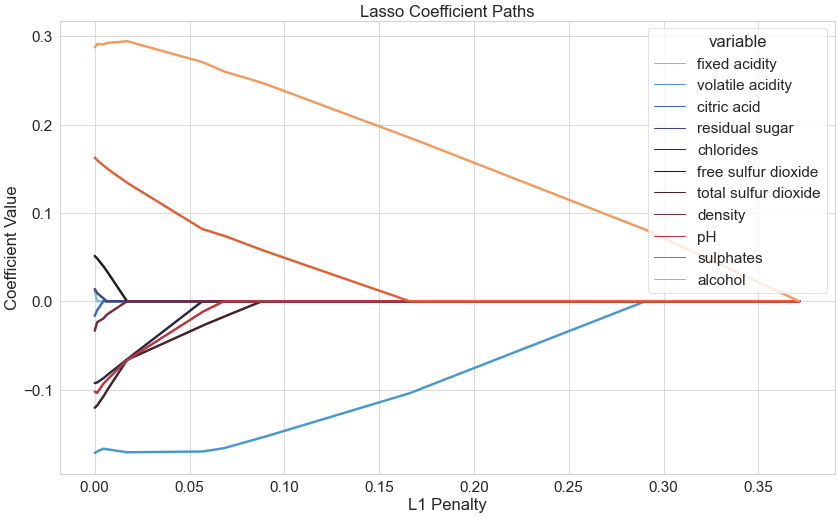

In [4]:
plt.figure(figsize=(20, 12));
visualization.lasso_plot(X_train,
                         y_train,
                         num_lambdas=5000,
                         features=list(train.columns[0:-1]));

---

### The Elastic Net

#### Introduction

The last form of regularized linear regression covered here is that of the Elastic Net. Having both $L_1$ and $L_2$ penalties, the Elastic Net serves to deliver a compromise between Ridge regression and the Lasso, bringing coefficients towards zero and selectively to zero. Cases where the number of features are much higher than the sample size and predictors are correlated in groups are the best cases in which to apply this model.

#### Solving the Elastic Net

The Elastic Net loss function is similar to the OLS loss function (3) but with the addition of an $L_1$ penalty and an $L_2$ penalty:

$$ L(\mathbf{\beta}) =  \|\mathbf{y} - \mathbf{X}\mathbf{\beta}\|_2^2 + \lambda_{1}\|\mathbf{\beta}\|_1 + \lambda_{2}\|\mathbf{\beta}\|_2 \: \: \: \text{ with tuning parameter $\lambda_1,\lambda_2 \geq 0$  } $$

The Lasso problem is also formalized as a least squares optimization problem: 

$$ \hat{\mathbf{\beta}} = \arg\min_{\mathbf{\beta}}  L(\mathbf{\beta}) = \arg\min_{\mathbf{\beta}} \|\mathbf{y}-\mathbf{X}\mathbf{\beta} \|_{2}^{2} + \lambda_{1}\|\mathbf{\beta}\|_1 + \lambda_{2}\|\mathbf{\beta}\|_2$$

Similarly to the Lasso, an intercept is included through design matrix augmentation and pathwise Coordinate Descent is implemented to solve.

#### Comparisons with Scikit-Learn

First, the features are standardized then a grid of tuning parameters is tested via five-fold cross-validation (CV). This grid consists of 2500 combinations of tuning parameters with each having a log spaced grid of 50 values between 0.0001 and 5.

In [4]:
elastic_net_cv = cv.elastic_net(X_train, y_train, num_lambdas=50, k=5)
tuning_params_elastic_net = elastic_net_cv[-1]
print("Optimal l1 tuning parameter value: ", tuning_params_elastic_net[0], \
      " Optimal l2 tuning parameter value: ", tuning_params_elastic_net[1])
utils.compare_elastic_net(X_train, y_train, test_vals, \
              features=list(train.columns[0:-1]), l1=tuning_params_elastic_net[0], l2=tuning_params_elastic_net[1])

Optimal l1 tuning parameter value:  1e-06  Optimal l2 tuning parameter value:  2448.4545380672153


,Runtime (s),Error,Y-Intercept,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
My Function,0.0950,112.3470,5.6470,0.0000e+00,-0.1695,-7.5711e-03,6.6027e-03,-9.0005e-02,4.4993e-02,-1.1389e-01,-2.0718e-02,-1.0051e-01,1.5748e-01,0.2926
Scikit-Learn's Function,0.0012,193.8449,5.6357,3.8439e-05,-0.0001,7.4019e-05,1.1141e-06,-4.0922e-05,-1.4749e-05,-5.8369e-05,-5.9504e-05,-2.5334e-05,8.7037e-05,0.0002


---

## Conclusion

Upon analysis of the modeling results, it appears that the Lasso model should be selected since it results in a lower error on the test set. It can be seen that the Lasso brought the coefficient for fixed acidity to zero, which makes intuitive sense considering that the multicollinearity analysis found fixed acidity to be most interdependent. By conducting this feature selection, the Lasso is able to derive a model with higher predictive accuracy. 

[Back to Top](#Table-of-Contents)

---